# Group Project Report

## Introduction

In school, the way used to measure a student’s knowledge is often through exams. To do well on exams, students often resort to spending as much time as possible to study in preparation for them. Nowadays, however, more and more people are emphasizing that studying more and getting high grades do not equate to gaining more knowledge. Thus, we want to investigate whether study time and exam results have an impact on a person’s knowledge level of that subject.

**The question we are trying to answer is: based on the time they spend studying and exam performance, what knowledge level would the user have on a subject?**

We are using the [User Knowledge Modeling](https://archive.ics.uci.edu/dataset/257/user+knowledge+modeling) dataset from the UCI Machine Learning Repository, donated by Kahraman, Colak, and Sagiroglu in 2013. There 403 observations which have been already split – 258 in the training dataset, and 145 in the testing set. The set contains no missing values. The dataset contains the following columns, in the order of left to right:

- user’s degree of study time for the goal subject materials (STG)
- user's the degree of repetition for studying the goal subject materials (SCG)
- user’s degree of study time for related subjects (STR)
- user's exam performance for related subjects (LPR)
- user's exam performance for the goal subject (PEG)
- user's knowledge level (UNS)-- classified as very low, low, middle, or high. 

Aside from UNS which indicates the knowledge level of users, the other columns are all dbl variables.

### Loading the Packages

In [61]:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(readxl)
library(dplyr)
library(yardstick)

library(tidymodels)

install.packages("ISLR")
install.packages("GGally")
install.packages("kknn")

library(kknn)
library(ISLR)
library(GGally)


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Reading, Wrangling, and Tidying Data

In [62]:
# reading data from url into jupyter

training_data <- read_csv("https://raw.githubusercontent.com/thisisyifulin/group_project-group34-/main/Training_Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv") |>
select(STG, SCG, STR, LPR, PEG, UNS)

testing_data <- read_csv("https://raw.githubusercontent.com/thisisyifulin/group_project-group34-/main/Test_Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv")



New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 145 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [63]:
head(training_data)
tail(training_data)

STG  SCG  STR  LPR  PEG  UNS     
1 0.00 0.00 0.00 0.00 0.00 very_low
2 0.08 0.08 0.10 0.24 0.90 High    
3 0.06 0.06 0.05 0.25 0.33 Low     
4 0.10 0.10 0.15 0.65 0.30 Middle  
5 0.08 0.08 0.08 0.98 0.24 Low     
6 0.09 0.15 0.40 0.10 0.66 Middle

STG  SCG  STR  LPR  PEG  UNS   
1 0.54 0.51 0.55 0.64 0.19 Low   
2 0.61 0.78 0.69 0.92 0.58 High  
3 0.78 0.61 0.71 0.19 0.60 Middle
4 0.54 0.82 0.71 0.29 0.77 High  
5 0.50 0.75 0.81 0.61 0.26 Middle
6 0.66 0.90 0.76 0.87 0.74 High

> <b> Figure 1: </b>
>
>The training data loaded from the web and present the first and final rows.

In [64]:
head(testing_data)
tail(testing_data)

STG  SCG  STR  LPR  PEG  UNS     
1 0.00 0.10 0.50 0.26 0.05 Very Low
2 0.05 0.05 0.55 0.60 0.14 Low     
3 0.08 0.18 0.63 0.60 0.85 High    
4 0.20 0.20 0.68 0.67 0.85 High    
5 0.22 0.22 0.90 0.30 0.90 High    
6 0.14 0.14 0.70 0.50 0.30 Low

STG  SCG  STR  LPR  PEG  UNS   
1 0.68 0.61 0.34 0.31 0.23 Low   
2 0.90 0.78 0.62 0.32 0.89 High  
3 0.85 0.82 0.66 0.83 0.83 High  
4 0.56 0.60 0.77 0.13 0.32 Low   
5 0.66 0.68 0.81 0.57 0.57 Middle
6 0.68 0.64 0.79 0.97 0.24 Middle

> <b> Figure 2: </b>
>
>The testing data loaded from the web and present the first and final rows.

In [65]:
# data is already tidy

### Summarizing the Data

Now, the data is already read. Our next step is to count and find the mean of each varibles for different category level of UNS. 

In [66]:
#summarize

counts_class <- training_data |>
                group_by(UNS) |>
                summarize(count_class = n())

mean_estimates<-training_data|>
group_by(UNS)|>
summarize(mean_STG=mean(STG),
          mean_TEG=mean(PEG),
          mean_SCG=mean(STG),
          mean_STR=mean(PEG),
            mean_LPR=mean(LPR))|>
select(-UNS)

summary<-counts_class|>
mutate(count=count_class)|>
select(-count_class)|>
cbind(mean_estimates)

summary

UNS      count mean_STG  mean_TEG   mean_SCG  mean_STR   mean_LPR 
1 High     63    0.4216508 0.77253968 0.4216508 0.77253968 0.5012698
2 Low      83    0.3211446 0.23762651 0.3211446 0.23762651 0.4973494
3 Middle   88    0.3999773 0.54238636 0.3999773 0.54238636 0.3428409
4 very_low 24    0.3057917 0.09083333 0.3057917 0.09083333 0.3587500

> <b> Figure 3: </b>
>
> The mean and count for each varibles (STG, PEG, SCG, STR and LPR) and UNS level.
?
> STG: user’s degree of study time for the goal subject materials
>
> PEG: user's exam performance for the goal subject
>
> SCG: user's the degree of repetition for studying the goal subject materials 
>
> STR: user’s degree of study time for related subjects
>
> LPR: user's exam performance for related subjects


According to the group_by and summarize function, we can see that for different UNS level, the mean of STG, TEG, SCG, STR and LPR are different. These means all these varibles are helpful to help us in predicting a new observation. But it is not realistic to use all varibles as the predictors, so we still need further operation to choose the decide the most useful variables.

In [67]:
#finds the mean of predictors

select_training_data <- training_data |>
select(STG, STR, LPR, PEG, UNS) # selecting the variables


#count the number of cells with na and renamed it into column count_ca
data_count_na <- summarize(select_training_data, count_na = sum(is.na(select_training_data)))

data_count_na
#since there are no n/a, there are no rows with n/a

count_na
1 0

><b> Figure 4: </b>
>
>The count of rows with missing values

### Exploratory Data Analysis — Visualizations

In order to use knn classification, we need to figure out the relationship between different variables. We want to pick PEG as one of our variables as we feel that exam performance is used most frequently as an indicator of someone's subject knowledge. We will be confirming the second variable to use with ggplot and ggpairs to measure the strength the relationship between different predictor variables and determine which variable has the strongest correlation with PEG

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


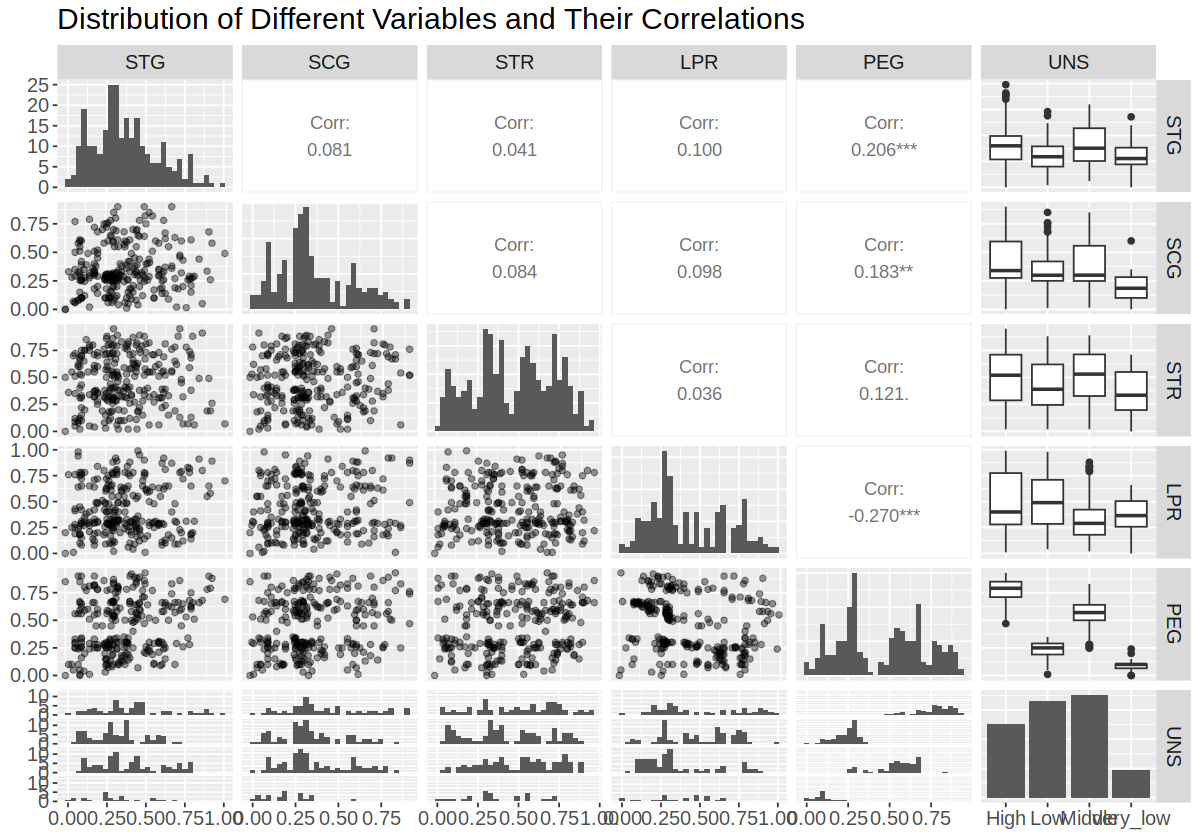

In [79]:
options(repr.plot.width = 10, repr.plot.height = 7)

pairplot <- training_data |> 
     ggpairs(
         lower = list(continuous = wrap('points', alpha = 0.4)),
         diag = list(continuous = "barDiag")) +
     theme(text = element_text(size = 15)) +
ggtitle("Distribution of Different Variables and Their Correlations")

pairplot

><b> Figure 5: </b>
>
>Pairplot comparing the distributions of the variables

Though we initially expected PEG and STG to have the highest correlation, since they are both related to goal subjects, the two variables which have the most correlation are LPR and PEG with -0.270. Therefore, we will be building our classification model with LPR and PEG as the variables. If we had more resources to perfect our model, we would also consider STG as a variable.

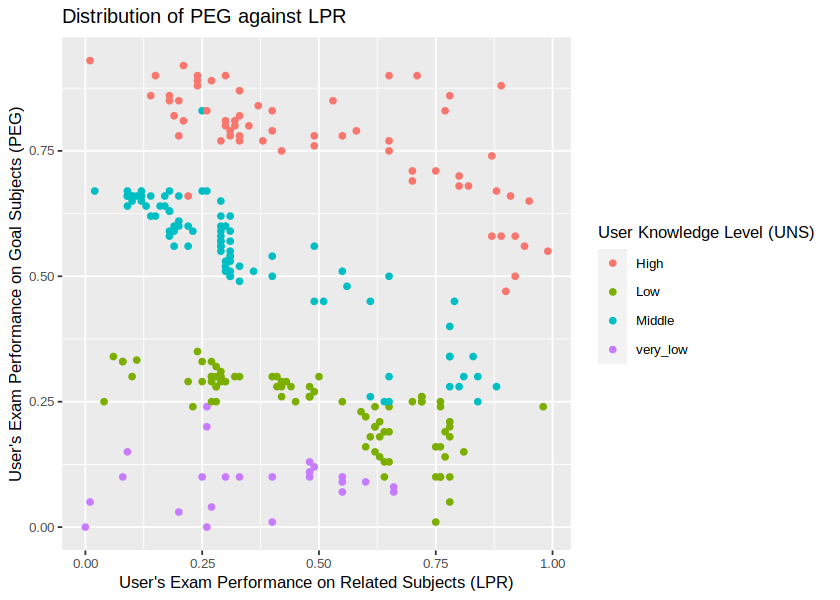

In [69]:
options(repr.plot.height = 5, repr.plot.width = 7)

lpr_peg_plot <- ggplot(training_data, aes(x = LPR, y = PEG)) +
geom_point(aes(color = UNS)) +
labs(x = "User's Exam Performance on Related Subjects (LPR)",
     y = "User's Exam Performance on Goal Subjects (PEG)",
     color = "User Knowledge Level (UNS)") +
theme(text = element_text(size = 10)) +
ggtitle("Distribution of PEG against LPR")
lpr_peg_plot

><b> Figure 6: </b>
>
>Visualization of the correlation between the two selected variables. We can see that a lower PEG seems to have a correlation with a lower UNS. However, it is not as clear what the correlation between LPR and UNS is.

With our exploratory data analysis, we predict that users who do well on subject goal exams will tend to have high user knowledge levels. Despite LPR having a higher correlation with PEG, it is unclear what studying more in related subjects indicates for the knowledge level.

## Methods

### Data Analysis — K-nearest neighbor classification

In order to creat a knn classification model to predict a new observation, we need to is to find out the most 
accurate k value to use. The first step in choosing the parameter K is to generate five different validation sets.
Then, creating a specification model and build a recipe that involve UNS as class, LPR and PEG as predictors.
Finally, we create a workflow and use the tune_grid function to fit the model for each value in a range of parameter values. Since the data was already pre-split, we do not need to split it again.


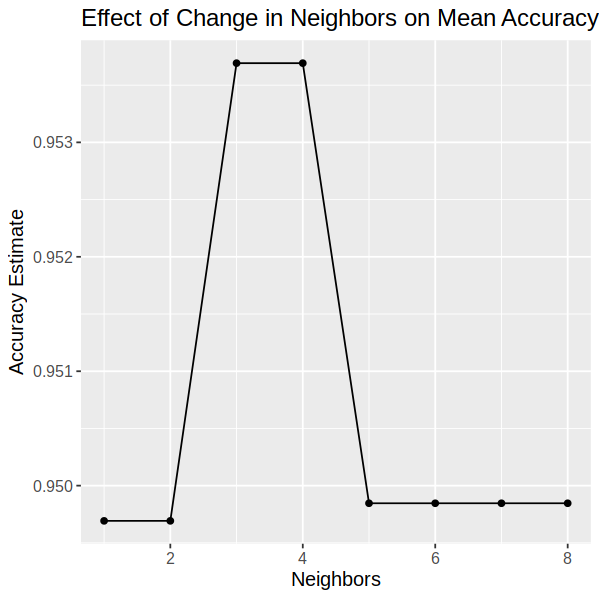

In [70]:
set.seed (1234)

options(repr.plot.height = 5, repr.plot.width = 5)

### BEGIN SOLUTION
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

mnist_recipe <- recipe(UNS ~ PEG + LPR, data = training_data)

mnist_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

knn_results <- workflow() |>
                 add_recipe(mnist_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = mnist_vfold, grid = tibble(neighbors = c(1,2,3,4,5,6,7,8))) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12)) +
ggtitle("Effect of Change in Neighbors on Mean Accuracy")

cross_val_plot

><b> Figure 7: </b>
>
>Graph of Accuracy against Neighbors. 3 and 4 produce the highest mean accuracy.

We see that we get highest accuracy with 3 and 4 neighbors, but since we have 4 classes, we will choose 3 so there is no tie between the classes. We now put k = 3 directly into the specification instead of using tune() function and create a workflow to combine the new specification and recipe. Finally, we fit the training data.

In [71]:
# mutating the training data
new_training_data<-training_data|>
select(UNS, LPR, PEG) |>
mutate(LPR=as.numeric(LPR))|>
mutate(PEG=as.numeric(PEG)) |>
mutate(UNS = as.factor(str_replace(training_data$UNS, "Very Low", "very_low"))) 


#m utating the testing data
new_testing_data<-testing_data|>
select(UNS, LPR, PEG)|>
mutate(LPR=as.numeric(LPR))|>
mutate(PEG=as.numeric(PEG)) |>
mutate(UNS = as.factor(str_replace(testing_data$UNS, "Very Low", "very_low")))

Here, we mutated the variables in order to fit the training data.

In [72]:
set.seed (1234)

# making a new prediction
pred1 <- tibble(LPR= 0.87, PEG=0.55)

# creating the recipe
recipe<-recipe(UNS~PEG+LPR, data=new_training_data)|>
 step_scale(all_predictors())|>
    step_center(all_predictors())

# creating the model
knn_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")

# fitting the training data
fit<- workflow() |>
          add_recipe(recipe) |>
          add_model(knn_spec) |>
          fit(data = new_training_data)

predicted1<-predict(fit, pred1)
predicted1

.pred_class
1 High



><b> Figure 8: </b>
>
>Predict a new observation's UNS level, checking to see if the program is functional.

Now, we check the accuracy of our classification model against the actual results.

In [73]:
set.seed (1234)

# fitting the testing data
test_predictions <- predict(fit, new_testing_data) |>
  bind_cols(new_testing_data)

# making the table of accuracies
classification_metrics <- test_predictions |>
metrics(truth = UNS, estimate=.pred_class)|>
filter(.metric == "accuracy")


classification_metrics

.metric  .estimator .estimate
1 accuracy multiclass 0.9517241

><b> Figure 9: </b>
>
>The accuracy of the k-nearest neighbor classification model

In [74]:
set.seed (1234)

# making the confusion matrix
conf_mat <- test_predictions |> 
      conf_mat(truth = UNS, estimate = .pred_class)

conf_mat

          Truth
Prediction High Low Middle very_low
  High       39   0      0        0
  Low         0  42      1        2
  Middle      0   3     33        0
  very_low    0   1      0       24

><b> Figure 10: </b>
>
>The confusion matrix of our predictions

We assign the testing data into the classification model and compare the predictions and the actual UNS level of 
the observations in the testing dataset to get the accuracy of our model. We can combine the predictions with 
our actual dataset together and use metrics to calculate the accuracy.

We can see the accuracy is around 95%, which makes this a successful model. However, we are still curious what role does the predictor LPR play in this model as it does not show its importance in the scatter plot. We will run the accuracy test again but this time with just predictor PEG.

In [75]:
set.seed (1234)
recipe_PEG<-recipe(UNS~PEG, data=new_training_data)|>
 step_scale(all_predictors())|>
    step_center(all_predictors())



fit_PEG<- workflow() |>
          add_recipe(recipe_PEG) |>
          add_model(knn_spec) |>
          fit(data = new_training_data)

test_predictions_PEG <- predict(fit_PEG, new_testing_data) |>
  bind_cols(new_testing_data)


classification_metrics_PEG <- test_predictions_PEG |>
metrics(truth = UNS, estimate=.pred_class)|>
filter(.metric == "accuracy")


classification_metrics_PEG


.metric  .estimator .estimate
1 accuracy multiclass 0.8068966

><b> Figure 11: </b>
>
>Accuracy metric with PEG as the only predictor.

As we removed the predictor LPR, the accuracy of the model dropped, indicating that LPR still plays an important role in this model. We now plot our predictions next to the true model to visualize how accurate it is.

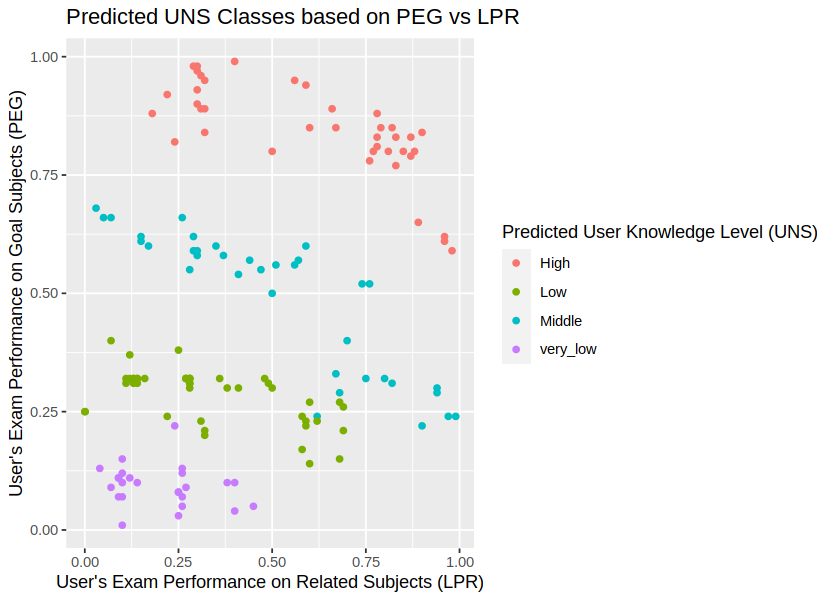

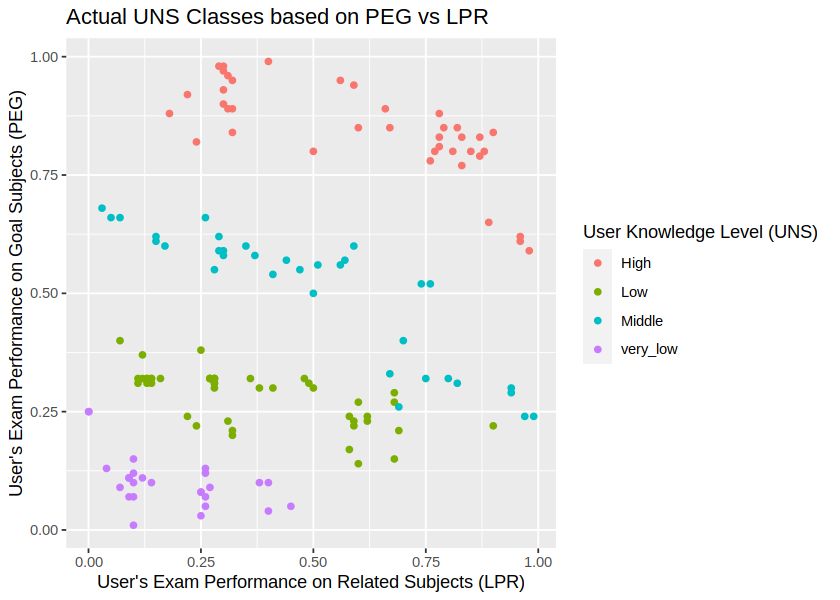

In [76]:
set.seed (1234)
options(repr.plot.height = 5, repr.plot.width = 7)

# plotting the graph our model predicted
prediction_plot <- ggplot(test_predictions, aes(x = LPR, y = PEG)) +
geom_point(aes(color = .pred_class)) +
labs(x = "User's Exam Performance on Related Subjects (LPR)",
     y = "User's Exam Performance on Goal Subjects (PEG)",
     color = "Predicted User Knowledge Level (UNS)") +
ggtitle("Predicted UNS Classes based on PEG vs LPR")

# plotting the graph of the true points
actual_plot <- ggplot(test_predictions, aes(x = LPR, y = PEG)) +
geom_point(aes(color = UNS)) +
labs(x = "User's Exam Performance on Related Subjects (LPR)",
     y = "User's Exam Performance on Goal Subjects (PEG)",
     color = "User Knowledge Level (UNS)") +
ggtitle("Actual UNS Classes based on PEG vs LPR")

prediction_plot
actual_plot

><b> Figure 12: </b>
>
>Plots of the actual data and of our predictions.

As we can see, our prediction are generally the same as the actual data. Thus, our model is overall successful in predicting UNS.

### Summary of Methods
In the analysis section, we begin by summarizing key characteristics of the dataset, focusing on mean exam perforamce, study time, and observations with missing values. Using ggpair and ggplot, we identify LPR and PEG as crucial predictors, with UNS as the target class for our knn classification.

We proceed with cross-validation, tuning the classifier and perform an linear model to find an optimal k-value for our knn model. Both k = 3 and k = 4 has the same accuracy, and we chose k = 3 to prevent a tie for our 4 classifier. The final model, built with k = 3, achieves a 95% accuracy on the testing dataset. Moving forward, we summarize the distribution of false positives and false negatives, finding potential areas of improvement.

A crucial aspect of our analysis involves understanding the individual contributions of PEG and LPR in our prediction model. With performing the model with a single predictor, we can conclude that PEG plays a dominant role in predictions, while LPR consistently supports the model's outcomes.

## Discussions

Using the k-nearest neighbors (KNN) model, we achieved an impressive 95% accuracy in predicting a user's knowledge level based on the exam performance predictors PEG (exam performance on the goal subject) and LPR (exam performance on related subjects). In our model, predictor PEG seems to be playing a crucial role in predicting knowledge levels, as we achieve 80% accuracy in predicting user knowledge levels when using it as the only predictor. LPR, on the other hand, plays a minor role in influencing predictions. It is surprising to note that there is no significant correlation between study time and exam performance, posing an unresolved question for our model. While we recognize that LPR is not the same as study time for the goal subject, it could still be an indicator of the user's study time in general for all their subjects. Additionally, understanding related subjects often correlates with understanding the goal subject. This observation aligns with Morrison's perspective, suggesting that study outcomes may not always correlate with the time invested (2016); rather, the effectiveness of study methods plays a more crucial role. Further investigation into the dynamics between study habits and academic outcomes will be needed to fully answer the question. It is also interesting that LPR has a negative correlation with PEG, meaning that as LPR increases, PEG decreases. This could indicate that time management plays a key role in knowledge level.


Despite the uncertainty regarding the relationship between study time and exam performance, our model aligns with our initial hypothesis: individuals with higher exam performance tend to have a higher knowledge level. This generally aligns with what the University of Waterloo's Centre for Teaching Excellence stated: exams are a way to help students learn from a different perspective and take away from their mistakes (2013). Since exams can also be a source of motivation for students to review subject material, those who perform well on exams have likely unconsciously gained a high knowledge level. 


The goal of this model is to help students and educators better understand how to approach learning and assessments, and we hope that our research findings have the potential to reshape perspectives and drive educational changes, leading to potential improvements in learning and assessment methods. We believe that these outcomes can contribute to a positive impact on the educational landscape, fostering continuous improvement and adaptation to evolving needs and challenges.

<b> Some future questions the findings could hypothetically lead to are: </b>

- How can educators better structure exams so that students can gain a higher knowledge level?

While researching on the topic, we found many sources which claim that exams are not a good method to measure learning. However, our results indicate otherwise. Therefore, we believe that there may be ways to adjust exam structures which allow students to gain more knowledge.

- If study time does not necessarily correlate with having a high knowledge level, which study methods (i.e. repetition) could be used to help students retain a high knowledge level?

As we see with the little correlation study time has to knowledge level, this could indicate that study methods are what truly makes a difference in gaining a high knowledge level. Studies can be conducted on different studying methods to discover which ones have the highest correlation with knowledge levels.

- If a student has a high knowledge level of one subject, will it be easier for them to gain a high knowledge level of a related subject?

This was an aspect we were not able to explore, due to time and resource constraints. Exploring how related subjects affect each other can help educators plan more cohesive teaching curriculums to better educate students.

## References

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

Morrison, N. (2016). The Secret of Effective Learning May Be Less Study, Not More. Forbes. https://www.forbes.com/sites/nickmorrison/2016/05/30/the-secret-of-effective-learning-may-be-less-study-not-more/?sh=759e31818c7e

Preparing tests and exams. Centre for Teaching Excellence. (2023, November 14). https://uwaterloo.ca/centre-for-teaching-excellence/catalogs/tip-sheets/preparing-tests-and-exams 